## Model was made to classify if client quited or stayed in company.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')
%matplotlib inline

In [3]:
df = pd.read_csv('CompanyData.csv')

## Checking data

In [9]:
df.columns

Index(['Klient', 'Netto', 'VAT', 'Brutto', 'Koszt', 'COUNTA z Klient', 'Ilość',
       'Zysk', 'Marża', 'tenure', 'quit'],
      dtype='object')

In [11]:
df.describe()

,COUNTA z Klient,quit
count,5492.000000,4822.000000
mean,4.442280,0.887391
std,15.297015,0.316147
min,0.000000,0.000000
25%,1.000000,1.000000
50%,1.000000,1.000000
75%,2.000000,1.000000
max,399.000000,1.000000


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5492 entries, 0 to 5491
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Klient           5492 non-null   object 
 1   Netto            5492 non-null   object 
 2   VAT              4822 non-null   object 
 3   Brutto           5492 non-null   object 
 4   Koszt            5492 non-null   object 
 5   COUNTA z Klient  5492 non-null   int64  
 6   Ilość            5492 non-null   object 
 7   Zysk             5492 non-null   object 
 8   Marża            4299 non-null   object 
 9   tenure           4822 non-null   object 
 10  quit             4822 non-null   float64
dtypes: float64(1), int64(1), object(9)
memory usage: 472.1+ KB


In [15]:
df.isna().sum()

Klient                0
Netto                 0
VAT                 670
Brutto                0
Koszt                 0
COUNTA z Klient       0
Ilość                 0
Zysk                  0
Marża              1193
tenure              670
quit                670
dtype: int64

In [17]:
# Replace commas with dots in columns
df[['VAT', 'Marża', 'Netto', 'Brutto', 'Koszt', 'Ilość', 'Zysk', 'tenure']] = df[['VAT', 'Marża', 'Netto', 'Brutto', 'Koszt', 'Ilość', 'Zysk', 'tenure']].apply(lambda x: x.str.replace(',', '.')).astype(float)

In [19]:
# Convert VAT column to numeric, forcing errors to NaN
df['VAT'] = pd.to_numeric(df['VAT'], errors='coerce')
# Convert Marża column to numeric, forcing errors to NaN
df['Marża'] = pd.to_numeric(df['Marża'], errors='coerce')
# Fill NaN values with the mean of the VAT column
df['VAT'] = df['VAT'].fillna(df['VAT'].mean())
df['Marża'] = df['Marża'].fillna(df['Marża'].mean())

In [21]:
df.isna().sum()

Klient               0
Netto                0
VAT                  0
Brutto               0
Koszt                0
COUNTA z Klient      0
Ilość                0
Zysk                 0
Marża                0
tenure             670
quit               670
dtype: int64

In [23]:
# Drop remaining NaN values
df = df.dropna()
df.isna().sum()

Klient             0
Netto              0
VAT                0
Brutto             0
Koszt              0
COUNTA z Klient    0
Ilość              0
Zysk               0
Marża              0
tenure             0
quit               0
dtype: int64

In [25]:
df = df.drop(['Klient'], axis=1)
df.head(15)

,Netto,VAT,Brutto,Koszt,COUNTA z Klient,Ilość,Zysk,Marża,tenure,quit
0,106.00,24.38,130.3800,41.40,1,0.0,0.00,54.58879,0.0,1.0
2,184.00,42.32,226.3200,73.32,1,0.0,0.00,54.58879,0.0,1.0
3,626.20,144.03,770.2300,284.52,1,0.0,0.00,54.58879,0.0,1.0
4,73.01,16.79,89.8000,45.00,1,0.0,0.00,54.58879,0.0,1.0
6,880.00,202.40,1082.4000,311.48,1,0.0,0.00,54.58879,0.0,0.0
7,96.75,22.25,119.0000,39.90,1,0.0,0.00,54.58879,0.0,1.0
9,292.00,33.58,359.1600,85.00,1,6.0,103.50,83.66000,0.0,1.0
10,166.00,38.18,204.1800,30.60,1,0.0,0.00,54.58879,0.0,1.0
11,248.00,28.52,305.0400,81.60,1,7.0,83.20,81.11000,0.0,1.0
12,648.00,74.52,797.0400,273.84,1,12.0,187.08,57.74000,0.0,1.0


We still have multiple potential problems here like Zysk (profit) happens to has value "0".

## ANN model

In [36]:
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, roc_auc_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

# Dane wejściowe
X = df.drop('quit', axis=1)
y = df.quit

# Zbalansowanie danych za pomocą SMOTE
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

# One-hot encoding for target
y = to_categorical(y)

In [38]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


In [40]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping

# Budowa modelu
model = Sequential()

# Warstwy wejściowe i ukryte
model.add(Dense(56, kernel_initializer='normal', activation='tanh', input_shape=(X_train.shape[1],)))
model.add(Dropout(rate=0.2))
model.add(BatchNormalization())

model.add(Dense(56, kernel_initializer='normal', activation='tanh'))
model.add(Dropout(rate=0.2))
model.add(BatchNormalization())

model.add(Dense(56, kernel_initializer='normal', activation='tanh'))
model.add(Dropout(rate=0.2))
model.add(BatchNormalization())

model.add(Dense(56, kernel_initializer='normal', activation='tanh'))
model.add(Dropout(rate=0.2))
model.add(BatchNormalization())

# Warstwa wyjściowa
model.add(Dense(2, kernel_initializer='normal', activation='sigmoid'))

# Kompilacja modelu z dodatkowymi metrykami
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'mae'])

# Wczesne zatrzymanie
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Trenowanie modelu
model_history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, callbacks=[early_stopping])

Epoch 1/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7473 - loss: 0.5347 - mae: 0.3574 - val_accuracy: 0.4964 - val_loss: 0.6638 - val_mae: 0.4710
Epoch 2/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7569 - loss: 0.5199 - mae: 0.3444 - val_accuracy: 0.7474 - val_loss: 0.5613 - val_mae: 0.3976
Epoch 3/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7549 - loss: 0.5127 - mae: 0.3431 - val_accuracy: 0.7715 - val_loss: 0.5262 - val_mae: 0.3683
Epoch 4/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7628 - loss: 0.5000 - mae: 0.3318 - val_accuracy: 0.7854 - val_loss: 0.4682 - val_mae: 0.3141
Epoch 5/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7558 - loss: 0.5074 - mae: 0.3335 - val_accuracy: 0.7912 - val_loss: 0.4633 - val_mae: 0.3225
Epoch 6/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7653 - loss: 0.5068 - mae: 0.3330 - val_accuracy: 0.7964 - val_loss: 0.4514 - val_mae: 0.2991
Epoch 7/100
172/172 ━━━━━━━━━━━━━━

In [41]:
# Ocena modelu
loss, accuracy, mae = model.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7990 - loss: 0.4497 - mae: 0.2846
Accuracy: 0.8014
Mean Absolute Error (MAE): 0.2808


In [42]:
# Predykcja
y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)
y_true = y_test.argmax(axis=1)

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [43]:
# Obliczenie metryk F1-score i AUC
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes))

auc = roc_auc_score(y_true, y_pred[:, 1])
print(f'\nAUC: {auc:.4f}')


Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.79      0.80       841
           1       0.80      0.81      0.81       871

    accuracy                           0.80      1712
   macro avg       0.80      0.80      0.80      1712
weighted avg       0.80      0.80      0.80      1712


AUC: 0.8725


In [44]:
# Wykresy strat i dokładności
epochs = range(1, len(model_history.history['loss']) + 1)

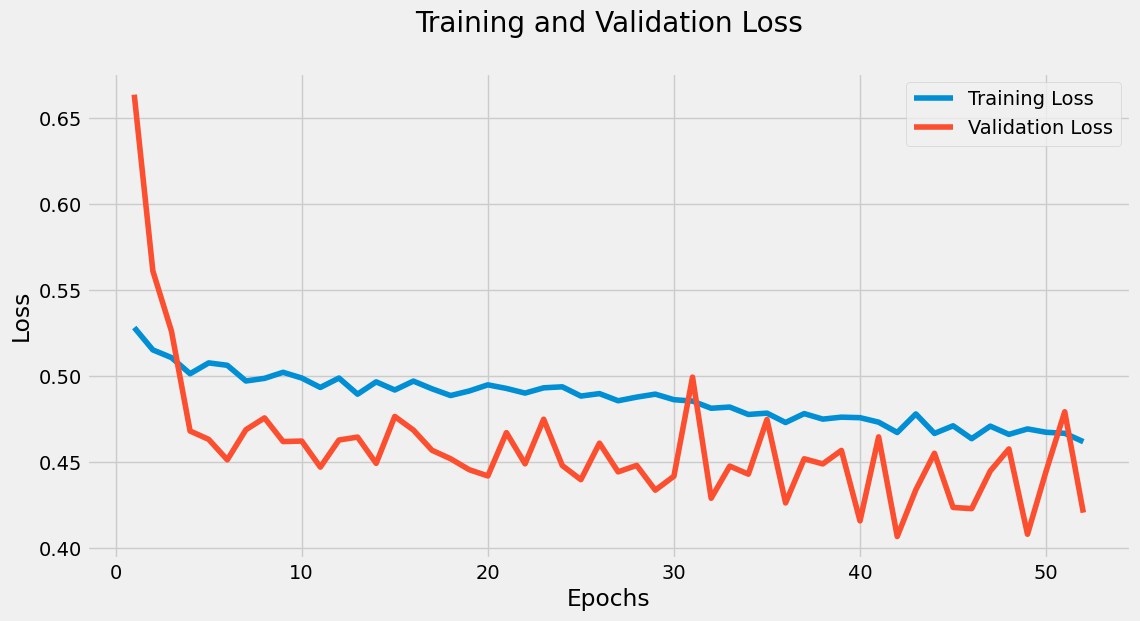

In [45]:
# Extract training and validation loss from the history
train_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
sns.lineplot(x=epochs, y=train_loss, label='Training Loss')
sns.lineplot(x=epochs, y=val_loss, label='Validation Loss')
plt.title('Training and Validation Loss\n')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

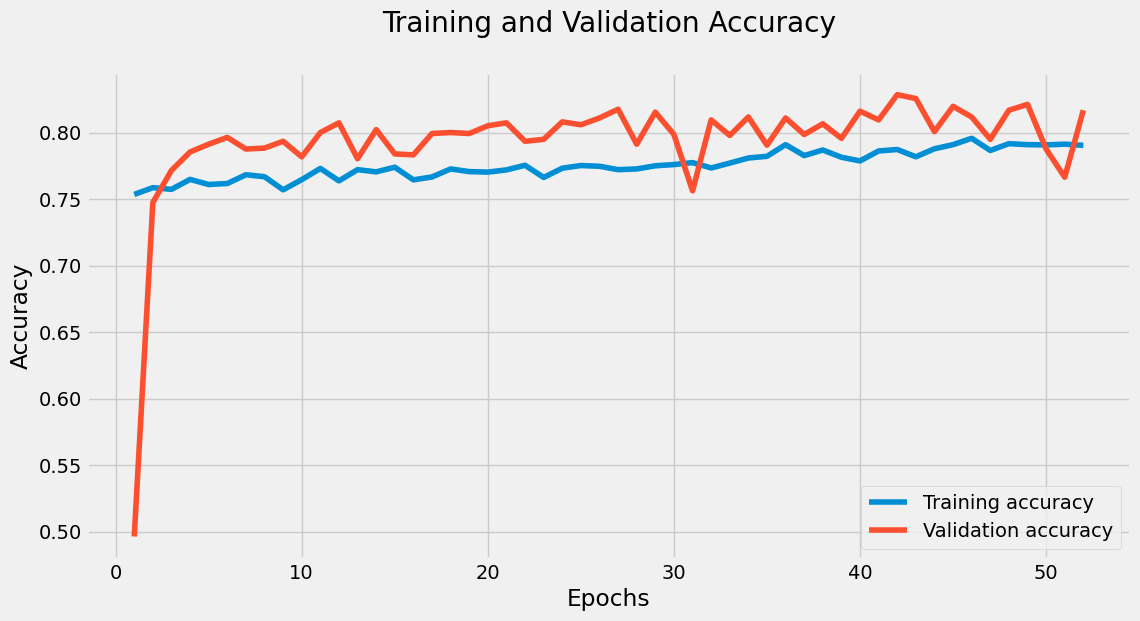

In [46]:
plt.figure(figsize=(12, 6))

train_loss = model_history.history['accuracy']
val_loss = model_history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Use x and y keyword arguments for sns.lineplot
sns.lineplot(x=epochs, y=train_loss, label='Training accuracy')
sns.lineplot(x=epochs, y=val_loss, label='Validation accuracy')

plt.title('Training and Validation Accuracy\n')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [47]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 56)             │           560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 56)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 56)             │           224 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 56)             │         3,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 56)             │           224 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 56)             │         3,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 56)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56)             │           224 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 56)             │         3,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 56)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 56)             │           224 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │           114 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,544 (127.13 KB)

 Trainable params: 10,698 (41.79 KB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 21,398 (83.59 KB)

## Analiza wyników modelu

In [50]:
count_1 = 0
count_0 = 0

for value in df['quit']:
    if value == 1:
        count_1 += 1
    elif value == 0:
        count_0 += 1

print(f"Quited: {count_1}")
print(f"Stayed: {count_0}")

Quited: 4279
Stayed: 543


In [51]:
# Liczenie procentowego udziału wartości 1 i 0
count_total = len(df['quit'])
percent_1 = (count_1 / count_total) * 100
percent_0 = (count_0 / count_total) * 100

print(f"Procentowy udział wartości 1 w kolumnie 'quit': {percent_1:.2f}%")
print(f"Procentowy udział wartości 0 w kolumnie 'quit': {percent_0:.2f}%")

Procentowy udział wartości 1 w kolumnie 'quit': 88.74%
Procentowy udział wartości 0 w kolumnie 'quit': 11.26%


The model was evaluated using several metrics, including Accuracy, MAE, Classification Report, and AUC:
1. Accuracy: 0.8026 (80.26%) - indicates that the model correctly classified approximately 80% of the test examples.
2. Mean Absolute Error (MAE): 0.2874 - shows the average error between the predictions and actual values, which is not the key metric for classification but can provide additional insight into model stability.
3. Classification Report:
- Precision: For class `0` it is 0.80, and for class `1` it is 0.81. This means that the model performs well in predicting both classes.
- Recall: For class `0` it is 0.80, and for class `1` it is 0.80. This shows that the model is able to detect instances of both classes with similar effectiveness.
- F1-score: The F1-score values for both classes are around 0.80, indicating a balance between precision and recall.
4. AUC: 0.8620 - indicates that the model distinguishes well between classes `0` and `1`. A higher AUC value indicates better capabilities in recognizing differences between classes.
  
Overall, the model achieved balanced results for both classes, but there is room for further optimization by adjusting hyperparameters, applying regularization, or rebalancing the data.
